<a href="https://colab.research.google.com/github/haujla2391/CSCI-4170/blob/main/CSCI4170_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/likithagedipudi/campus-placement-prediction

This has student profiles for predicting campus placement outcomes.

# Part 1

In [115]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy.cluster.hierarchy as sch

In [96]:
class NeuralNetwork:
  def __init__(self, layer_sizes, learning_rate=0.01, random_state=42):
    self.layer_sizes = layer_sizes
    self.lr = learning_rate
    self.random_state = random_state
    np.random.seed(random_state)

    self.weights = []
    self.biases = []

    # initialize the structure
    for i in range(len(layer_sizes) - 1):
      fan_in = layer_sizes[i]
      limit = np.sqrt(1.0 / fan_in) * 0.01
      W = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1]))    # randomly initialize weights using a small scaling for sigmoid
      b = np.zeros((1, layer_sizes[i+1]))
      self.weights.append(W)
      self.biases.append(b)

    self.activations = []
    self.zs = []

  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def sigmoid_derivative(self, a):
    return a * (1 - a)

  def forward(self, X):
    self.activations = [X]           # A[0] = input
    self.zs = []

    A = X
    for i in range(len(self.weights)):
      Z = np.dot(A, self.weights[i]) + self.biases[i]         # z_1 = W_1 X^T + b_1
      self.zs.append(Z)
      if i == len(self.weights) - 1:
          # Output layer: sigmoid for binary classification
          A = self.sigmoid(Z)
      else:
          A = self.sigmoid(Z)   # hidden layers also sigmoid (classic style)
      self.activations.append(A)

    return A

  def backward(self, X, y_true):
    m = X.shape[0]
    y_pred = self.activations[-1] # This is A_L

    # Calculate initial dL/dZ for the output layer
    # dL/dA_L = (y_pred - y_true) / m
    # dZ_L = dL/dA_L * sigmoid_derivative(A_L)
    dZ_current = ((y_pred - y_true) / m) * self.sigmoid_derivative(y_pred) # This is dL/dZ_L

    dW_list = []
    db_list = []

    # Loop backwards through the layers (from output layer's weights to input layer's weights)
    for l in range(len(self.weights) - 1, -1, -1):
      A_prev = self.activations[l] # Activation from the layer before W_l

      dW = np.dot(A_prev.T, dZ_current)
      db = np.sum(dZ_current, axis=0, keepdims=True)

      dW_list.insert(0, dW)
      db_list.insert(0, db)

      # Calculate dZ for the previous layer (if not the input layer)
      if l > 0:
          # dL/dZ_l = (dL/dZ_{l+1} @ W_l.T) * sigmoid_derivative(A_l)
          # Where dZ_current is dL/dZ_{l+1} and self.weights[l] is W_l
          dZ_current = np.dot(dZ_current, self.weights[l].T) * self.sigmoid_derivative(self.activations[l])

    # Update weights and biases (gradient descent step)
    for i in range(len(self.weights)):
      self.weights[i] -= self.lr * dW_list[i]
      self.biases[i] -= self.lr * db_list[i]

  def cost(self, y_true, y_pred):
    m = y_true.shape[0]
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
    return loss

  def train(self, X, y, epochs=1000, batch_size=64, verbose=True):
    m = X.shape[0]
    losses = []

    for epoch in range(epochs):
      # Shuffle data each epoch
      indices = np.random.permutation(m)
      X_shuffled = X[indices]
      y_shuffled = y[indices]

      epoch_loss = 0
      num_batches = 0

      for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # Forward
        y_pred = self.forward(X_batch)

        # Loss
        batch_loss = self.cost(y_batch, y_pred)
        epoch_loss += batch_loss * X_batch.shape[0]
        num_batches += X_batch.shape[0]

        # Backward + update
        self.backward(X_batch, y_batch)

      avg_loss = epoch_loss / num_batches
      losses.append(avg_loss)

      if verbose and (epoch + 1) % 50 == 0:
          print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    return losses

  def predict(self, X, threshold=0.5):
    probs = self.forward(X)
    return (probs >= threshold).astype(int)

  def predict_proba(self, X):
    return self.forward(X)

In [97]:
path = "data/campus_placement_data.csv"
df = pd.read_csv(path)

print("Data shape", df.shape)

print(df.info())

print(df.isnull().sum())

df.drop(columns=['specialization'], inplace=True)

print("Duplicated columns: ", df.duplicated().sum())

Data shape (100000, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   student_id                  100000 non-null  object 
 1   gender                      100000 non-null  object 
 2   age                         100000 non-null  int64  
 3   city_tier                   100000 non-null  object 
 4   ssc_percentage              100000 non-null  float64
 5   ssc_board                   100000 non-null  object 
 6   hsc_percentage              100000 non-null  float64
 7   hsc_board                   100000 non-null  object 
 8   hsc_stream                  100000 non-null  object 
 9   degree_percentage           100000 non-null  float64
 10  degree_field                100000 non-null  object 
 11  mba_percentage              100000 non-null  float64
 12  specialization              35035 non-null   obje

In [109]:
X = df.select_dtypes(include='number').drop(columns=['placed', 'salary_lpa']).to_numpy()     # drop both target columns
y = df['placed'].to_numpy()                                                                  # choose one target
y = y.reshape(-1, 1)

In [110]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [111]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Epoch 50/800, Loss: 0.422799
Epoch 100/800, Loss: 0.381466
Epoch 150/800, Loss: 0.348556
Epoch 200/800, Loss: 0.343609
Epoch 250/800, Loss: 0.341742
Epoch 300/800, Loss: 0.340117
Epoch 350/800, Loss: 0.338970
Epoch 400/800, Loss: 0.337938
Epoch 450/800, Loss: 0.337125
Epoch 500/800, Loss: 0.336147
Epoch 550/800, Loss: 0.335803
Epoch 600/800, Loss: 0.335177
Epoch 650/800, Loss: 0.335215
Epoch 700/800, Loss: 0.334680
Epoch 750/800, Loss: 0.334395
Epoch 800/800, Loss: 0.334101


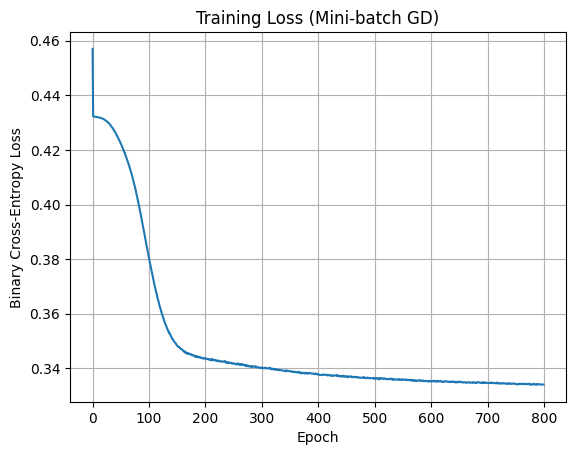

Train Accuracy:   0.8590
Val   Accuracy:   0.8577
Test  Accuracy:   0.8553


In [112]:
custom_nn = NeuralNetwork(
    layer_sizes=[16, 32, 16, 1],
    learning_rate=0.05,
    random_state=42
)

# Train with mini-batch GD
history = custom_nn.train(
    X_train, y_train,
    epochs=800,
    batch_size=128,
    verbose=True
)

plt.plot(history)
plt.title("Training Loss (Mini-batch GD)")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True)
plt.show()

y_pred_train = custom_nn.predict(X_train)
y_pred_val   = custom_nn.predict(X_val)
y_pred_test  = custom_nn.predict(X_test)

print("Train Accuracy:   {:.4f}".format(accuracy_score(y_train, y_pred_train)))
print("Val   Accuracy:   {:.4f}".format(accuracy_score(y_val,   y_pred_val)))
print("Test  Accuracy:   {:.4f}".format(accuracy_score(y_test,  y_pred_test)))

I used Mini-batch gradient descent because I have 60k data points and so normal gradient descent would take a very long time to run. Mini batch allows me to have batches of my data be passed at a time and so the runtime is much faster for my epochs. This approach strikes a good balance between the stability of full batch gradient descent and the speed of stochastic gradient descent, leading to efficient training.

# Part 2

## Task 1

https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

I have worked with PyTorch before for designing a neural network so I used this link to go over the basic set up again. I used this resource aminly for the device setup because I had forgotten how to do so.

https://github.com/haujla2391/MNIST-Classifier-Python

I also used this link, which is my project I made for a Neural Network before, to review the basic model setup and the train and test setups.

## Task 2

### EDA

Text(0.5, 1.0, 'Placement Outcome Distribution by Gender')

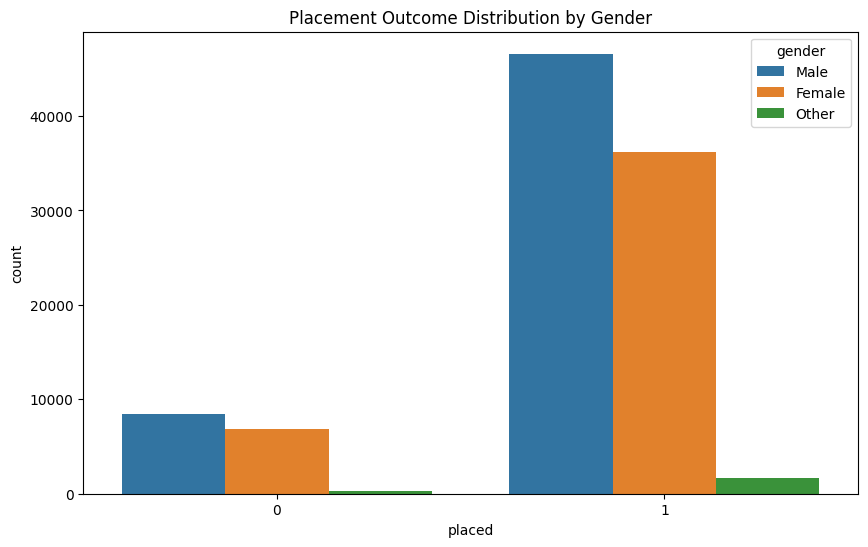

In [102]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='placed', hue='gender')
plt.title("Placement Outcome Distribution by Gender")

The heatmap shows that there are high correlations between technical skills, soft skills, communication skills as well as degree, ssc, hsc percentages. These strong correlations suggest that these skill and academic performance metrics move together, which could be useful for feature engineering or understanding latent factors affecting placement.

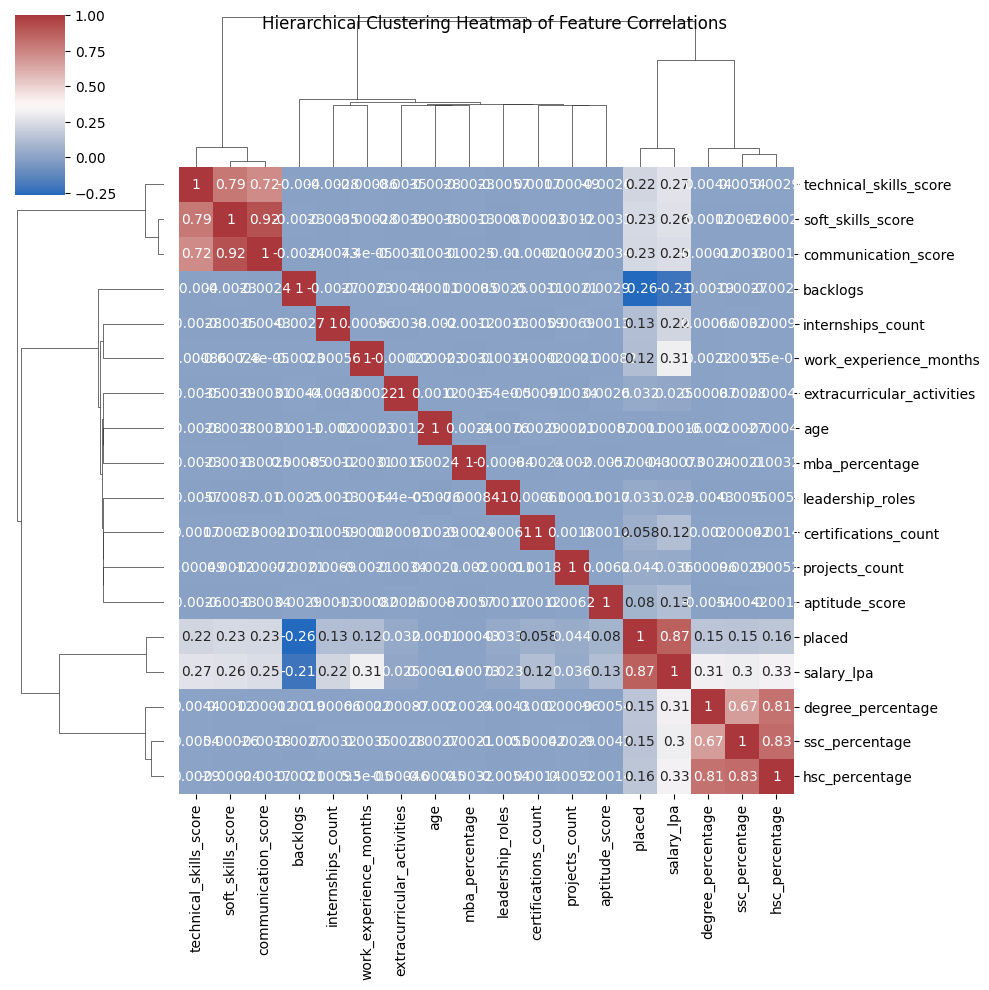

In [103]:
# Compute correlation
num_df = df.select_dtypes(include=["int64", "float64"])
corr = num_df.corr()

# Dendrogram
dendro = sch.linkage(corr, method="ward")
sns.clustermap(corr, row_linkage=dendro, col_linkage=dendro, cmap="vlag", annot=True)
plt.suptitle("Hierarchical Clustering Heatmap of Feature Correlations")
plt.show()

The heatmap shows that there are high correlations between technical skills, soft skills, communication skills as well as degree, ssc, hsc percentages.

### Transform data

In [113]:
# Turn our already normalized data into tensors
X = df.select_dtypes(include='number').drop(columns=['placed', 'salary_lpa'])                 # drop both target columns
y = df['placed']                                                                              # choose one target

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

### Forward Prop

In [116]:
class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.forwardProp = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.forwardProp(x)
    return logits

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NN().to(device)
print(model)

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (forwardProp): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [118]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 50
weight_decay = 1e-5

In [119]:
# Get our data loaders for epochs
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Cost function

In [120]:
m = NN().to(device)
optimizer = optim.Adam(m.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCELoss()

### Gradient Descent and Training

In [121]:
# train
train_losses, val_losses = [], []

for epoch in range(num_epochs):
  train_loss = 0.0

  m.train()
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device).unsqueeze(1)

    optimizer.zero_grad()

    outputs = m(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  # validation
  val_loss = 0.0

  m.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device).unsqueeze(1)

      outputs = m(inputs)
      loss = criterion(outputs, labels)

      val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  val_losses.append(avg_val_loss)

  print(f"Epoch {(epoch + 1)}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1: Train Loss: 0.3368, Val Loss: 0.3286
Epoch 2: Train Loss: 0.3299, Val Loss: 0.3273
Epoch 3: Train Loss: 0.3271, Val Loss: 0.3262
Epoch 4: Train Loss: 0.3267, Val Loss: 0.3252
Epoch 5: Train Loss: 0.3257, Val Loss: 0.3237
Epoch 6: Train Loss: 0.3254, Val Loss: 0.3239
Epoch 7: Train Loss: 0.3252, Val Loss: 0.3237
Epoch 8: Train Loss: 0.3252, Val Loss: 0.3233
Epoch 9: Train Loss: 0.3250, Val Loss: 0.3232
Epoch 10: Train Loss: 0.3254, Val Loss: 0.3244
Epoch 11: Train Loss: 0.3244, Val Loss: 0.3229
Epoch 12: Train Loss: 0.3247, Val Loss: 0.3223
Epoch 13: Train Loss: 0.3241, Val Loss: 0.3235
Epoch 14: Train Loss: 0.3246, Val Loss: 0.3230
Epoch 15: Train Loss: 0.3243, Val Loss: 0.3250
Epoch 16: Train Loss: 0.3247, Val Loss: 0.3220
Epoch 17: Train Loss: 0.3242, Val Loss: 0.3229
Epoch 18: Train Loss: 0.3244, Val Loss: 0.3229
Epoch 19: Train Loss: 0.3244, Val Loss: 0.3250
Epoch 20: Train Loss: 0.3243, Val Loss: 0.3225
Epoch 21: Train Loss: 0.3243, Val Loss: 0.3223
Epoch 22: Train Loss: 

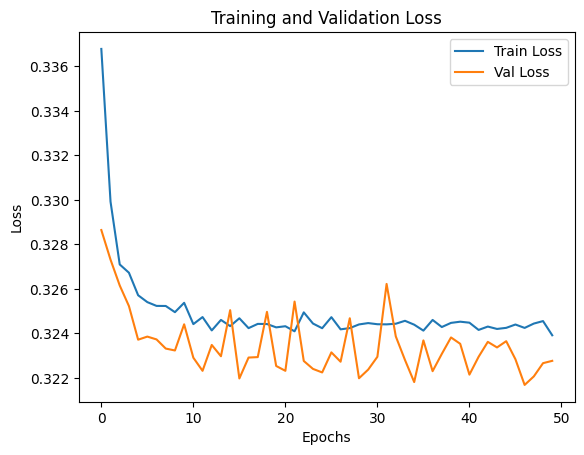

In [122]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Test set

In [123]:
test_loss = 0.0
correct, total = 0, 0

model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device).unsqueeze(1)

    outputs = m(inputs)
    loss = criterion(outputs, labels)

    test_loss += loss.item()

    predicted = (outputs > 0.5).float()
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
accuracy = correct / total * 100

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.3232
Test Accuracy: 85.73%


## Task 3

I chose the hyperparameters: `learning rate = 0.01` and `num_epochs = 50` and they did not make much difference in accuracy compared to 0.001 and 20 epochs. Both got 85% accuracy. The technique I used was hand tuning, just changing the values to known ones that perform well for the learning rate and epochs. I first did not use regularization but then I added `weight decay = 1e-5` and the accuracy improved slightly, and was better than 1e-6 and 1e-3. I used an optimization algorithm of Adam because it is usually the go to algorthm in PyTorch, and it has good generalization compared to other methods. The choice of Adam optimizer, coupled with weight decay, helps to prevent overfitting and achieve a more robust model performance.